In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Set visual style for plots
sns.set_theme(style="whitegrid")

In [7]:
# Load the dataset
# Note: Update the path if your file is in a different directory
df = pd.read_csv('dirty_cafe_sales.csv')
df_cleaned = df.copy()

# Step 1: Replace invalid entries with NaN
invalid_values = ['ERROR', 'UNKNOWN', '']
df_cleaned.replace(invalid_values, np.nan, inplace=True)

# Step 2: Convert data types
numerical_cols = ['Quantity', 'Price Per Unit', 'Total Spent']
for col in numerical_cols:
    df_cleaned[col] = pd.to_numeric(df_cleaned[col], errors='coerce')

# Convert Transaction Date to datetime
df_cleaned['Transaction Date'] = pd.to_datetime(df_cleaned['Transaction Date'], errors='coerce')

# Recalculate Total Spent where missing but Quantity and Price exist
valid_calc = df_cleaned['Quantity'].notna() & df_cleaned['Price Per Unit'].notna()
df_cleaned.loc[df_cleaned['Total Spent'].isna() & valid_calc, 'Total Spent'] = \
    df_cleaned['Quantity'] * df_cleaned['Price Per Unit']

In [8]:
# 3a: Numerical Imputation (using Median)
for col in numerical_cols:
    if df_cleaned[col].isnull().any():
        median_val = df_cleaned[col].median()
        df_cleaned[col] = df_cleaned[col].fillna(median_val)

# 3b: Categorical Imputation (using Placeholder 'Missing')
categorical_cols = ['Item', 'Payment Method', 'Location']
for col in categorical_cols:
    df_cleaned[col] = df_cleaned[col].fillna('Missing')

# 3c: Date Imputation (using Mode)
mode_date = df_cleaned['Transaction Date'].mode()[0]
df_cleaned['Transaction Date'] = df_cleaned['Transaction Date'].fillna(mode_date)

In [9]:
# Extract time-based features
df_cleaned['Transaction Month'] = df_cleaned['Transaction Date'].dt.month.astype(str)
df_cleaned['Transaction Day'] = df_cleaned['Transaction Date'].dt.day.astype(str)
df_cleaned['Transaction Weekday'] = df_cleaned['Transaction Date'].dt.day_name()

# Drop columns that won't be used in the model
df_modeling = df_cleaned.drop(columns=['Transaction ID', 'Transaction Date'])

# One-Hot Encoding for categorical variables
categorical_features = ['Item', 'Payment Method', 'Location', 'Transaction Month', 'Transaction Day', 'Transaction Weekday']
df_encoded = pd.get_dummies(df_modeling, columns=categorical_features, drop_first=False)

# Convert boolean columns to integer (1/0)
for col in df_encoded.columns:
    if df_encoded[col].dtype == 'bool':
        df_encoded[col] = df_encoded[col].astype(int)

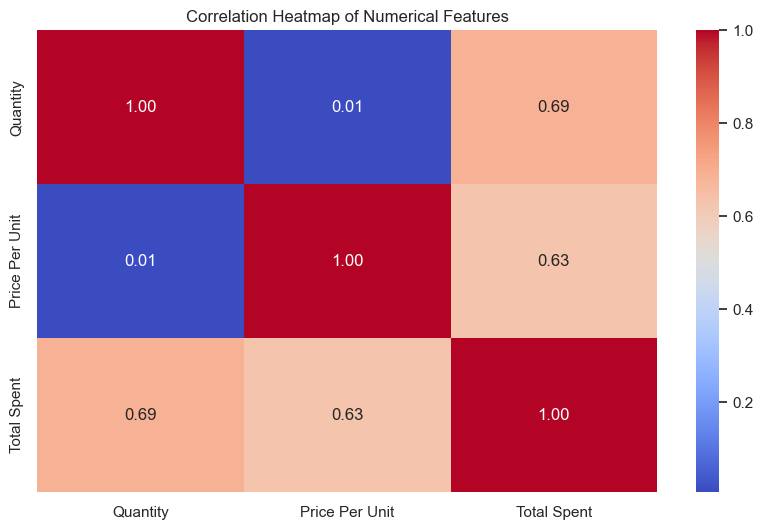

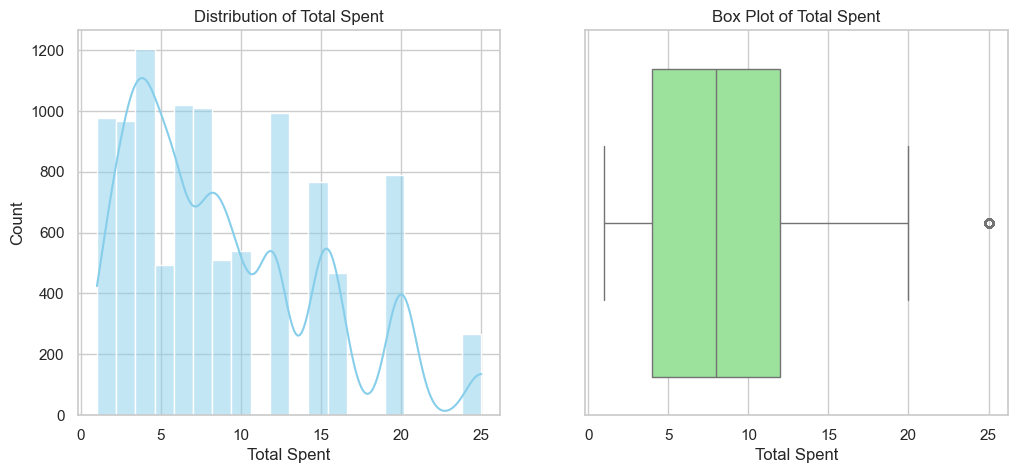

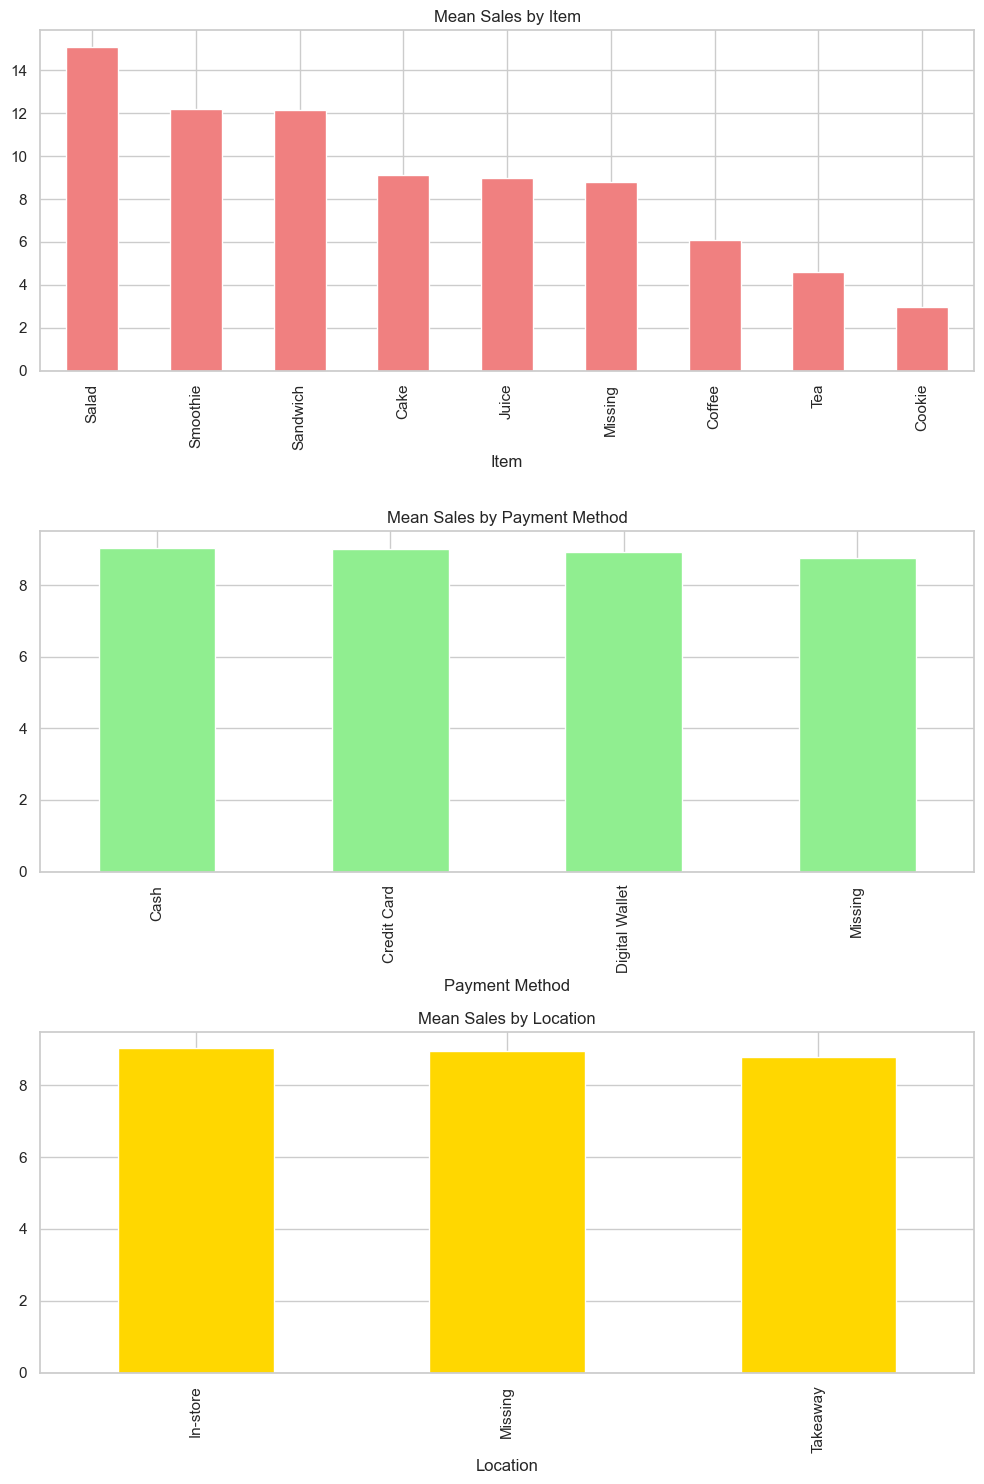

In [10]:
# --- A. Correlation Heatmap ---
plt.figure(figsize=(10, 6))
corr = df_cleaned[['Quantity', 'Price Per Unit', 'Total Spent']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

# --- B. Distribution of Total Spent ---
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(df_cleaned['Total Spent'], bins=20, kde=True, color='skyblue')
plt.title('Distribution of Total Spent')

plt.subplot(1, 2, 2)
sns.boxplot(x=df_cleaned['Total Spent'], color='lightgreen')
plt.title('Box Plot of Total Spent')
plt.show()

# --- C. Mean Sales by Category ---
fig, axes = plt.subplots(3, 1, figsize=(10, 15))

item_sales = df_cleaned.groupby('Item')['Total Spent'].mean().sort_values(ascending=False)
payment_sales = df_cleaned.groupby('Payment Method')['Total Spent'].mean().sort_values(ascending=False)
location_sales = df_cleaned.groupby('Location')['Total Spent'].mean().sort_values(ascending=False)

item_sales.plot(kind='bar', ax=axes[0], color='lightcoral', title='Mean Sales by Item')
payment_sales.plot(kind='bar', ax=axes[1], color='lightgreen', title='Mean Sales by Payment Method')
location_sales.plot(kind='bar', ax=axes[2], color='gold', title='Mean Sales by Location')

plt.tight_layout()
plt.show()

In [11]:
# Prepare features (X) and target (y)
X = df_encoded.drop('Total Spent', axis=1)
y = df_encoded['Total Spent']

# 80/20 Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Linear Regression (Baseline) ---
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
print(f"LR - RMSE: {mean_squared_error(y_test, y_pred_lr, squared=False):.4f}")
print(f"LR - MAE: {mean_absolute_error(y_test, y_pred_lr):.4f}")

# --- Random Forest Regressor ---
rfr = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=10)
rfr.fit(X_train, y_train)
y_pred_rfr = rfr.predict(X_test)
print(f"\nRFR - RMSE: {mean_squared_error(y_test, y_pred_rfr, squared=False):.4f}")
print(f"RFR - MAE: {mean_absolute_error(y_test, y_pred_rfr):.4f}")

# Save the final cleaned data
df_cleaned.to_csv('cleaned_cafe_sales.csv', index=False)

c:\Users\mohib\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


LR - RMSE: 2.1724
LR - MAE: 1.5186

RFR - RMSE: 1.1187
RFR - MAE: 0.2741


c:\Users\mohib\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
